https://www.kaggle.com/fernandol/countries-of-the-world/data

In [1]:
# Import statements! Are loans given to people who actually need it, 3 more files, contain poverty index of every country
from functools import reduce
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, Imputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

In [2]:
loans = pd.read_csv("data-science-for-good-kiva-crowdfunding/kiva_loans.csv")
mpi_locations = pd.read_csv("data-science-for-good-kiva-crowdfunding/kiva_mpi_region_locations.csv")
world_countries = pd.read_csv("data-science-for-good-kiva-crowdfunding/countries of the world.csv", thousands = '.')

# First let's do all the data work with world_countries data set

In [3]:
world_countries["Country"] = world_countries["Country"].str.strip()

In [4]:
world_countries.loc[world_countries["Country"] == 'Albania']

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"


In [5]:
world_countries = world_countries.fillna('0') # It's not the best solution but we must do this to work with the comma separated values

In [6]:
for k in range(0, len(world_countries)):
    
    world_countries["Coastline (coast/area ratio)"][k] = world_countries["Coastline (coast/area ratio)"][k].replace(',','.')
    world_countries["Net migration"][k] = world_countries["Net migration"][k].replace(',','.')
    world_countries["Infant mortality (per 1000 births)"][k] = world_countries["Infant mortality (per 1000 births)"][k].replace(',','.')
    world_countries["Literacy (%)"][k] = world_countries["Literacy (%)"][k].replace(',','.')
    world_countries["Phones (per 1000)"][k] = world_countries["Phones (per 1000)"][k].replace(',','.')
    world_countries["Arable (%)"][k] = world_countries["Arable (%)"][k].replace(',','.')
    world_countries["Crops (%)"][k] = world_countries["Crops (%)"][k].replace(',','.')
    world_countries["Other (%)"][k] = world_countries["Other (%)"][k].replace(',','.')
    world_countries["Birthrate"][k] = world_countries["Birthrate"][k].replace(',','.')
    world_countries["Deathrate"][k] = world_countries["Deathrate"][k].replace(',','.')
    world_countries["Agriculture"][k] = world_countries["Agriculture"][k].replace(',','.')
    world_countries["Industry"][k] = world_countries["Industry"][k].replace(',','.')
    world_countries["Service"][k] = world_countries["Service"][k].replace(',','.')
    world_countries["Pop. Density (per sq. mi.)"][k] = world_countries["Pop. Density (per sq. mi.)"][k].replace(',','.')



/home/shelob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/shelob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/shelob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/h

In [7]:
world_countries_revise = pd.DataFrame.copy(world_countries)

In [8]:
world_countries_revise["Coastline (coast/area ratio)"] = pd.to_numeric(world_countries["Coastline (coast/area ratio)"])
world_countries_revise["Infant mortality (per 1000 births)"] = pd.to_numeric(world_countries["Infant mortality (per 1000 births)"])
world_countries_revise["Literacy (%)"] = pd.to_numeric(world_countries["Literacy (%)"])
world_countries_revise["Phones (per 1000)"] = pd.to_numeric(world_countries["Phones (per 1000)"])
world_countries_revise["Arable (%)"] = pd.to_numeric(world_countries["Arable (%)"])
world_countries_revise["Crops (%)"] = pd.to_numeric(world_countries["Crops (%)"])
world_countries_revise["Other (%)"] = pd.to_numeric(world_countries["Other (%)"])
world_countries_revise["Net migration"] = pd.to_numeric(world_countries["Net migration"])
world_countries_revise["Birthrate"] = pd.to_numeric(world_countries["Birthrate"])
world_countries_revise["Deathrate"] = pd.to_numeric(world_countries["Deathrate"])
world_countries_revise["Agriculture"] = pd.to_numeric(world_countries["Agriculture"])
world_countries_revise["Industry"] = pd.to_numeric(world_countries["Industry"])
world_countries_revise["Service"] = pd.to_numeric(world_countries["Service"])
world_countries_revise["GDP ($ per capita)"] = pd.to_numeric(world_countries["GDP ($ per capita)"])
world_countries_revise["Pop. Density (per sq. mi.)"] = pd.to_numeric(world_countries["Pop. Density (per sq. mi.)"])

In [9]:
mpi_locations.head(5)

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


In [10]:
loans.head(1)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01


In [11]:
world_countries.head(1)

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700,36.0,3.2,12.13,0.22,87.65,1,46.6,20.34,0.38,0.24,0.38


In [12]:
loans_no_nan = loans[pd.notnull(loans['region'])]

In [13]:
loans_merge = pd.merge(loans_no_nan, mpi_locations, on = 'region')

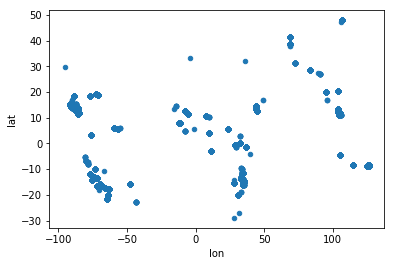

In [14]:
loans_merge.plot(kind = "scatter", x="lon", y="lat")
plt.show()

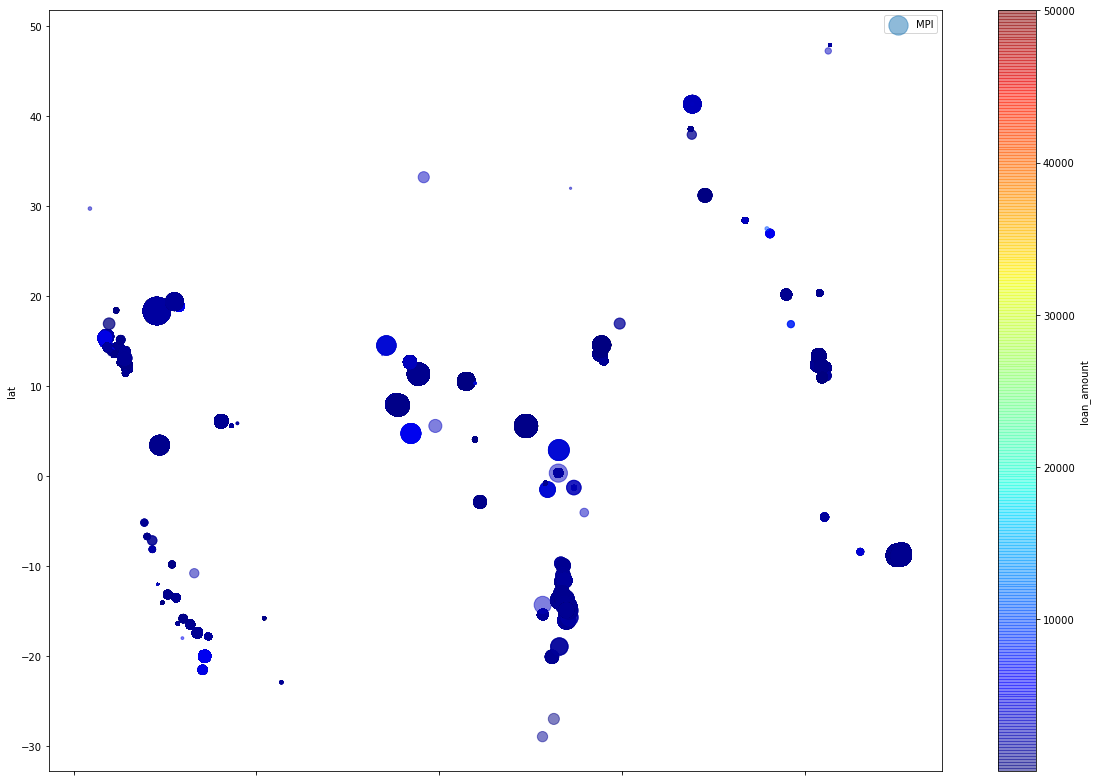

In [15]:
loans_merge.plot(kind = "scatter", x="lon", y="lat", alpha = .5,
                  s = loans_merge["MPI"] * 1000 , label = "MPI", figsize = (20, 14),
                  c = "loan_amount", cmap = plt.get_cmap("jet"), colorbar = True,
                  )
plt.legend()
plt.show()

In [16]:
copy = pd.DataFrame.copy(loans_merge)

In [17]:
copy = copy.drop("geo", 1)
copy = copy.drop("country_code", 1)
copy = copy.drop("use", 1)
copy = copy.drop("partner_id", 1)
copy = copy.drop("disbursed_time", 1)
copy = copy.drop("funded_time", 1)
copy = copy.drop("date", 1)
copy = copy.drop("tags", 1)
copy = copy.drop("ISO", 1)
copy = copy.drop("country_y", 1)
copy = copy.drop("world_region", 1)
copy = copy.drop("posted_time", 1)
copy = copy.drop("id", 1)
copy = copy.drop("region", 1)
copy = copy.drop("currency", 1)
copy = copy.drop("LocationName", 1)
copy = copy.drop("lat", 1)
copy = copy.drop("lon", 1)

In [18]:
copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60158 entries, 0 to 60157
Data columns (total 10 columns):
funded_amount         60158 non-null float64
loan_amount           60158 non-null float64
activity              60158 non-null object
sector                60158 non-null object
country_x             60158 non-null object
term_in_months        60158 non-null float64
lender_count          60158 non-null int64
borrower_genders      60158 non-null object
repayment_interval    60158 non-null object
MPI                   60158 non-null float64
dtypes: float64(4), int64(1), object(5)
memory usage: 5.0+ MB


In [19]:
copy.head()

,funded_amount,loan_amount,activity,sector,country_x,term_in_months,lender_count,borrower_genders,repayment_interval,MPI
0,600.0,600.0,Machinery Rental,Services,Nicaragua,14.0,16,female,monthly,0.031
1,1000.0,1000.0,Grocery Store,Food,Nicaragua,14.0,20,male,monthly,0.031
2,250.0,250.0,Fuel/Firewood,Retail,Nicaragua,14.0,8,female,monthly,0.031
3,175.0,175.0,Food Market,Food,Nicaragua,14.0,5,female,monthly,0.031
4,800.0,800.0,Clothing Sales,Clothing,Nicaragua,9.0,7,"female, female, female",monthly,0.031


In [20]:
copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60158 entries, 0 to 60157
Data columns (total 10 columns):
funded_amount         60158 non-null float64
loan_amount           60158 non-null float64
activity              60158 non-null object
sector                60158 non-null object
country_x             60158 non-null object
term_in_months        60158 non-null float64
lender_count          60158 non-null int64
borrower_genders      60158 non-null object
repayment_interval    60158 non-null object
MPI                   60158 non-null float64
dtypes: float64(4), int64(1), object(5)
memory usage: 5.0+ MB


In [21]:
encoder = LabelEncoder()

In [22]:
sector_cat = copy["sector"]
activity_cat = copy["activity"]
country_cat = copy["country_x"]
# region_cat = copy_2["region"]
gender_cat = copy["borrower_genders"]
repay_cat = copy["repayment_interval"]

In [23]:
# region_cat = region_cat.fillna('Other Region')
gender_cat = gender_cat.fillna('Other Gender')

In [24]:
sector_encode = encoder.fit_transform(sector_cat)
activity_encode = encoder.fit_transform(activity_cat)
# region_encode = encoder.fit_transform(region_cat)
gender_encode = encoder.fit_transform(gender_cat)
repay_encode = encoder.fit_transform(repay_cat)
# climate_encode = encoder.fit_transform(climate_cat)
country_encode = encoder.fit_transform(country_cat)

In [25]:
copy["sector"] = sector_encode
copy["activity"] = activity_encode
# copy["region"] = region_encode
copy["borrower_genders"] = gender_encode
copy["repayment_interval"] = repay_encode
# copy["Climate"] = climate_encode
copy["country_x"] = country_encode

In [26]:
imputer = Imputer(strategy = "median")

In [27]:
imputer.fit(copy)
X = imputer.transform(copy)
transform_of_copy = pd.DataFrame(X, columns = copy.columns)
transform_of_copy

,funded_amount,loan_amount,activity,sector,country_x,term_in_months,lender_count,borrower_genders,repayment_interval,MPI
0,600.0,600.0,85.0,12.0,25.0,14.0,16.0,0.0,2.0,0.031
1,1000.0,1000.0,70.0,6.0,25.0,14.0,20.0,665.0,2.0,0.031
2,250.0,250.0,64.0,11.0,25.0,14.0,8.0,0.0,2.0,0.031
3,175.0,175.0,60.0,6.0,25.0,14.0,5.0,0.0,2.0,0.031
4,800.0,800.0,31.0,2.0,25.0,9.0,7.0,2.0,2.0,0.031
5,800.0,800.0,70.0,6.0,25.0,13.0,31.0,0.0,2.0,0.031
6,400.0,400.0,31.0,2.0,25.0,13.0,14.0,0.0,2.0,0.031
7,1925.0,1925.0,70.0,6.0,25.0,10.0,60.0,8.0,1.0,0.031
8,250.0,250.0,31.0,2.0,25.0,10.0,9.0,0.0,2.0,0.031
9,800.0,800.0,70.0,6.0,25.0,17.0,27.0,0.0,2.0,0.031


In [28]:
train_set_copy, test_set_copy = train_test_split(transform_of_copy, test_size = 0.2, random_state = 42)

In [29]:
y_train = train_set_copy["country_x"]
y_test = test_set_copy["country_x"]
x_test = test_set_copy.drop("country_x", 1)
x_train = train_set_copy.drop("country_x", 1)

In [30]:
dt_clf = DecisionTreeClassifier(random_state = 42)

In [31]:
dt_clf.fit(x_train, y_train)
dt_clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [32]:
dt_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.])

In [33]:
cross_val_score(dt_clf, x_train, y_train, cv = 3, scoring = "accuracy")

/home/shelob/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


array([0.96605419, 0.96459074, 0.96668746])

In [34]:
y_train_predict_dt = cross_val_predict(dt_clf, x_train, y_train, cv = 3)
y_train_predict_dt

/home/shelob/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


array([25.,  5.,  3., ..., 25., 32., 26.])

In [35]:
confusion_dt = confusion_matrix(y_train, y_train_predict_dt)
confusion_dt

array([[104,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 564,   0,   0],
       [  0,   0,   0, ...,   0, 194,   0],
       [  0,   0,   0, ...,   0,   0, 676]])

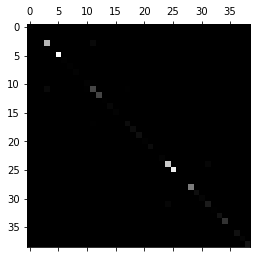

In [36]:
plt.matshow(confusion_dt, cmap = plt.cm.gray)
plt.show()

In [37]:
sum_of_row = confusion_dt.sum(axis = 1, keepdims = True)
norm_conf_dt = confusion_dt / sum_of_row

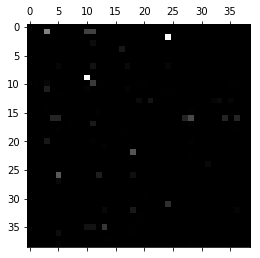

In [38]:
np.fill_diagonal(norm_conf_dt, 0)
plt.matshow(norm_conf_dt, cmap = plt.cm.gray)
plt.show()

In [39]:
precision_score(y_train, y_train_predict_dt, average = 'weighted')

/home/shelob/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.9656718260625536

In [40]:
recall_score(y_train, y_train_predict_dt, average = 'weighted')

0.9657773344969455

In [41]:
f1_score(y_train, y_train_predict_dt, average = 'weighted')

/home/shelob/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.9657088340298572

In [42]:
dt_predictions = dt_clf.predict(x_test) #predict how the classes from our test set
dt_predictions

array([ 3., 35.,  5., ...,  6., 32.,  5.])

In [43]:
print(accuracy_score(y_test, dt_predictions)) #88.5% accurate on our test set!!!!

0.9702460106382979


# Random Forest Comparison

In [44]:
random_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1)

In [45]:
random_clf.fit(x_train, y_train)
random_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [46]:
random_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.])

In [47]:
cross_val_score(random_clf, x_train, y_train, cv = 3, scoring = "accuracy")

/home/shelob/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


array([0.70401744, 0.70631507, 0.6959451 ])

In [48]:
y_train_predict_random = cross_val_predict(random_clf, x_train, y_train, cv = 3)
y_train_predict_random

/home/shelob/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


array([ 3.,  5.,  3., ..., 25., 25., 26.])

In [49]:
confusion_random = confusion_matrix(y_train, y_train_predict_random)
confusion_random

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

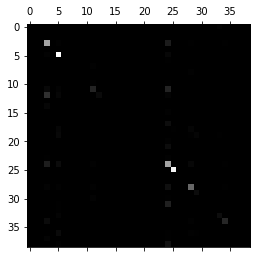

In [50]:
plt.matshow(confusion_random, cmap = plt.cm.gray)
plt.show()

In [51]:
sum_of_row_rf = confusion_random.sum(axis = 1, keepdims = True)
norm_conf_rf = confusion_random / sum_of_row_rf

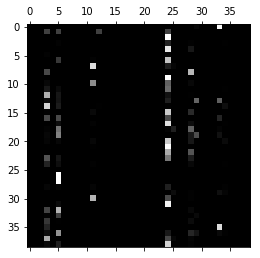

In [52]:
np.fill_diagonal(norm_conf_rf, 0)
plt.matshow(norm_conf_rf, cmap = plt.cm.gray)
plt.show()

In [53]:
precision_score(y_train, y_train_predict_random, average = 'weighted')

/home/shelob/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6511737533143127

In [54]:
recall_score(y_train, y_train_predict_random, average = 'weighted')

0.7023854049785978

In [55]:
f1_score(y_train, y_train_predict_random, average = 'weighted')

/home/shelob/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6508852923207786

In [56]:
random_predictions = random_clf.predict(x_test) #predict how the classes from our test set
random_predictions

array([ 3., 35.,  5., ...,  5., 25.,  5.])

In [57]:
print(accuracy_score(y_test, random_predictions)) 

0.7064494680851063


In [58]:
random_clf.feature_importances_

array([0.07237482, 0.10807654, 0.0155514 , 0.03381243, 0.10148607,
       0.02726037, 0.0270364 , 0.16751107, 0.4468909 ])

In [59]:
for name, score in zip(list(x_train), random_clf.feature_importances_):
    print(name, score) # remember these are percents, so multiply by 100

funded_amount 0.07237482308939548
loan_amount 0.10807654374034971
activity 0.015551404441631035
sector 0.033812434384063964
term_in_months 0.10148606758948356
lender_count 0.027260367474705383
borrower_genders 0.0270363978517271
repayment_interval 0.16751106622495393
MPI 0.4468908952036897


In [60]:
# copy_2 = pd.merge(copy, world_countries_revise, left_on = "country_x", right_on = "Country")

In [61]:
# copy_2.loc[copy_2["country_x"] == "El Salvador"]

In [62]:
# copy_2.info()

In [63]:
# copy_2["Climate"].value_counts() # We can encode this one

In [64]:
# copy_2 = copy_2.drop("Country", 1)
# copy_2 = copy_2.drop("Region", 1)

In [65]:
# copy_2 = copy_2.drop("Region", 1)

In [66]:
# copy_2 = copy_2.drop("currency", 1)

In [67]:
# copy_2 = copy_2.drop("LocationName", 1)

In [68]:
# copy_2["GDP ($ per capita)"] = pd.to_numeric(copy_2["GDP ($ per capita)"])

In [69]:
# encoder = LabelEncoder()

In [70]:
# sector_cat = copy_2["sector"]
# activity_cat = copy_2["activity"]
# country_cat = copy_2["country_x"]
# # region_cat = copy_2["region"]
# gender_cat = copy_2["borrower_genders"]
# repay_cat = copy_2["repayment_interval"]
# climate_cat = copy_2["Climate"]

In [71]:
# region_cat = region_cat.fillna('Other Region')
# gender_cat = gender_cat.fillna('Other Gender')

In [72]:
# sector_encode = encoder.fit_transform(sector_cat)
# activity_encode = encoder.fit_transform(activity_cat)
# region_encode = encoder.fit_transform(region_cat)
# gender_encode = encoder.fit_transform(gender_cat)
# repay_encode = encoder.fit_transform(repay_cat)
# climate_encode = encoder.fit_transform(climate_cat)
# country_encode = encoder.fit_transform(country_cat)

In [73]:
# copy_2["sector"] = sector_encode
# copy_2["activity"] = activity_encode
# copy_2["region"] = region_encode
# copy_2["borrower_genders"] = gender_encode
# copy_2["repayment_interval"] = repay_encode
# copy_2["Climate"] = climate_encode
# copy_2["country_x"] = country_encode

In [74]:
# copy_2.head()

In [75]:
# imputer = Imputer(strategy = "median")

In [76]:
# imputer.fit(copy_2)
# X = imputer.transform(copy_2)
# transform_world = pd.DataFrame(X, columns = copy_2.columns)
# transform_world

In [77]:
# %matplotlib inline
# transform_world.hist(bins = 50, figsize = (20, 15))
# plt.show()

In [78]:
# correlation_matrix = transform_world.corr()

In [79]:
# correlation_matrix["sector"].sort_values(ascending = False)

In [80]:
# correlation_matrix["country_x"].sort_values(ascending = False)

# Now let's experiement with some classification techniques!

In [81]:
# train_set, test_set = train_test_split(transform_world, test_size = 0.2, random_state = 42)

In [82]:
# y_train = train_set["sector"]
# y_test = test_set["sector"]
# x_test = test_set.drop("sector", 1)
# x_train = train_set.drop("sector", 1)

In [83]:
# dt_clf = DecisionTreeClassifier(random_state = 42)

In [84]:
# dt_clf.fit(x_train, y_train)
# dt_clf

In [85]:
# dt_clf.classes_

In [86]:
# cross_val_score(dt_clf, x_train, y_train, cv = 3, scoring = "accuracy")

In [87]:
# y_train_predict_dt = cross_val_predict(dt_clf, x_train, y_train, cv = 3)
# y_train_predict_dt

In [88]:
# confusion_dt = confusion_matrix(y_train, y_train_predict_dt)
# confusion_dt

In [89]:
# plt.matshow(confusion_dt, cmap = plt.cm.gray)
# plt.show()

In [90]:
# sum_of_row = confusion_dt.sum(axis = 1, keepdims = True)
# norm_conf_dt = confusion_dt / sum_of_row

In [91]:
# np.fill_diagonal(norm_conf_dt, 0)
# plt.matshow(norm_conf_dt, cmap = plt.cm.gray)
# plt.show()

In [92]:
# precision_score(y_train, y_train_predict_dt, average = 'weighted')

In [93]:
# recall_score(y_train, y_train_predict_dt, average = 'weighted')

In [94]:
# f1_score(y_train, y_train_predict_dt, average = 'weighted')

In [95]:
# dt_predictions = dt_clf.predict(x_test) #predict how the classes from our test set
# dt_predictions

In [96]:
# print(accuracy_score(y_test, dt_predictions)) #88.5% accurate on our test set!!!!

# Since the Decision Tree seems to be overfitting, lets try the Random Forest

In [97]:
# random_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1)

In [98]:
# random_clf.fit(x_train, y_train)
# random_clf

In [99]:
# random_clf.classes_

In [100]:
# cross_val_score(random_clf, x_train, y_train, cv = 3, scoring = "accuracy")

In [101]:
# y_train_predict_random = cross_val_predict(random_clf, x_train, y_train, cv = 3)
# y_train_predict_random

In [102]:
# confusion_random = confusion_matrix(y_train, y_train_predict_random)
# confusion_random

In [103]:
# plt.matshow(confusion_random, cmap = plt.cm.gray)
# plt.show()

In [104]:
# sum_of_row_rf = confusion_random.sum(axis = 1, keepdims = True)
# norm_conf_rf = confusion_random / sum_of_row_rf

In [105]:
# np.fill_diagonal(norm_conf_rf, 0)
# plt.matshow(norm_conf_rf, cmap = plt.cm.gray)
# plt.show()

In [106]:
# precision_score(y_train, y_train_predict_random, average = 'weighted')

In [107]:
# recall_score(y_train, y_train_predict_random, average = 'weighted')

In [108]:
# f1_score(y_train, y_train_predict_random, average = 'weighted')

In [109]:
# random_predictions = random_clf.predict(x_test) #predict how the classes from our test set
# random_predictions

In [110]:
# print(accuracy_score(y_test, random_predictions)) 

In [111]:
# random_clf.feature_importances_

In [112]:
# for name, score in zip(list(x_train), random_clf.feature_importances_):
#     print(name, score) # remember these are percents, so multiply by 100

In [113]:
# copy_2["country_x"].value_counts()